In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import torch
import torch_geometric
from torch_geometric.loader import DataLoader
from torch_geometric.nn import summary
import xarray as xr
import yaml

import Dataset
import Models
import Loss
from utils import time_func

In [2]:
print(f"Torch version: {torch.__version__}")
print(f"Cuda available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"Cuda device: {torch.cuda.get_device_name()}")
print(f"Cuda version: {torch.version.cuda}")
print(f"Torch geometric version: {torch_geometric.__version__}")

Torch version: 2.0.1+cu117
Cuda available: False
Cuda version: 11.7
Torch geometric version: 2.3.1


In [3]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE

device(type='cpu')

In [4]:
params = yaml.safe_load(open('./config/pipeline.yaml'))

DATA_PATH = params['input_subset_pre_processed']
MESH_PATH = params['input_subset_grid']

TRAIN_PROP = params['train_prop']
VAL_PROP = params['val_prop']
TEST_PROP = params['test_prop']
TRAIN_VAL_TEST = [TRAIN_PROP, VAL_PROP, TEST_PROP]

TRAIN_BATCH_SIZE = params['train_batch_size']
VAL_BATCH_SIZE = params['val_batch_size']
TEST_BATCH_SIZE = params['test_batch_size']

N_FEATURES = params['n_features']
HID_CHANNELS = params['hid_channels']
N_CLASSES = params['n_classes']

FINAL_ACT = None
if params['final_act'] == "sigmoid":
    FINAL_ACT = torch.sigmoid
elif params['final_act'] == "softmax":
    FINAL_ACT = torch.softmax
elif params['final_act'] == "linear":
    FINAL_ACT = torch.nn.Linear(1, 1)

LOSS_OP = None
if params['loss_op'] == "CE":
    LOSS_OP = torch.nn.CrossEntropyLoss()
elif params['loss_op'] == "WCE":
    class_weights = [0.0238, 0.4734, 0.5028]
    LOSS_OP = Loss.WeightedCrossEntropyLoss(class_weights)

OPTIMIZER = None
if params['optimizer'] == "Adam":
    OPTIMIZER = torch.optim.Adam

LEARN_RATE = params['learn_rate']

EPOCHS = params['epochs']

PLOT_SHOW = params['plot_show']
PLOT_FOLDER = params['output_images_path']

# TODO use this
PLOT_VERTICAL = params['plot_vertical']

TIMESTAMP = time_func.start_time()

### Dataset creation

In [5]:
timestamp = time_func.start_time()

train_dataset = Dataset.EddyDataset(root=DATA_PATH, mesh_path=MESH_PATH, split='train', proportions=TRAIN_VAL_TEST)

val_dataset = Dataset.EddyDataset(root=DATA_PATH, mesh_path=MESH_PATH, split='val', proportions=TRAIN_VAL_TEST)
#val_dataset.permutations = train_dataset.permutations

test_dataset = Dataset.EddyDataset(root=DATA_PATH, mesh_path=MESH_PATH, split='test', proportions=TRAIN_VAL_TEST)
#test_dataset.permutations = train_dataset.permutations

time_func.stop_time(timestamp, "Datasets creation")

    Shape of node feature matrix: torch.Size([239536, 1])
    Shape of graph connectivity in COO format: torch.Size([2, 1432160])
    Shape of labels: torch.Size([239536])
  ---  Datasets creation  ---  4.230 seconds.


In [6]:
#train_dataset.permutations[:10]

In [7]:
#val_dataset.permutations[:10]

In [8]:
#test_dataset.permutations[:10]

In [9]:
print(train_dataset.len(), val_dataset.len(), test_dataset.len())

292 36 37


In [10]:
#val_dataset[25]

### Testing some parameters and orientation of graph edges

In [11]:
if (TRAIN_PROP+VAL_PROP+TEST_PROP) != 100:
    raise ValueError(f"Sum of train-val-test proportions with value {TRAIN_PROP+VAL_PROP+TEST_PROP} is different from 100")

if FINAL_ACT == None:
    raise ValueError(f"Parameter 'final_act' is invalid with value {params['final_act']}")

if LOSS_OP == None:
    raise ValueError(f"Parameter 'loss_op' is invalid with value {params['loss_op']}")
else:
    if torch.cuda.is_available():
        LOSS_OP = LOSS_OP.cuda()

if OPTIMIZER == None:
    raise ValueError(f"Parameter 'optimizer' is invalid with value {params['optimizer']}")

dummy_graph = train_dataset[0]

if dummy_graph.num_features != N_FEATURES:
    raise ValueError(f"Graph num_features is different from parameter N_FEATURES: ({dummy_graph.num_features} != {N_FEATURES})")

if dummy_graph.is_directed():
    raise ValueError("Graph edges are directed!")

### Train-validation-test split

In [12]:
train_loader = DataLoader(train_dataset, batch_size=TRAIN_BATCH_SIZE, shuffle=True, num_workers=6, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=VAL_BATCH_SIZE, shuffle=False, num_workers=6, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=TEST_BATCH_SIZE, shuffle=False, num_workers=6, pin_memory=True)

print(len(train_loader.dataset), len(val_loader.dataset), len(test_loader.dataset))

292 36 37


### Model instantiation

In [13]:
Model = Models.GUNet

model = Model(
    in_channels = N_FEATURES,
    hidden_channels = HID_CHANNELS,
    out_channels = N_CLASSES,
    num_nodes = dummy_graph.num_nodes,   # TODO can put these in Dataset.py
    final_act = FINAL_ACT
).to(DEVICE)

model

GUNet instantiated!
	Middle act: relu
	Final act: softmax


GUNet(
  (unet): GraphUNet(1, 32, 3, depth=3, pool_ratios=[0.008349475652928996, 0.5, 0.5])
)

In [14]:
if torch.cuda.is_available():
    print(torch.cuda.memory_summary())
else:
    print(summary(model, dummy_graph))

+-------------------------------+-------------------------------------------------+-------------------------------------------------------+----------+
| Layer                         | Input Shape                                     | Output Shape                                          | #Param   |
|-------------------------------+-------------------------------------------------+-------------------------------------------------------+----------|
| GUNet                         | [239536, 239536]                                | [239536, 3]                                           | 5,539    |
| ├─(unet)GraphUNet             | [239536, 1], [2, 1432160]                       | [239536, 3]                                           | 5,539    |
| │    └─(down_convs)ModuleList | --                                              | --                                                    | 3,232    |
| │    │    └─(0)GCNConv        | [239536, 1], [2, 1432160], [1432160]            | [239536, 3

/home/b/b382485/miniconda3/envs/eddy-tracking/lib/python3.8/site-packages/torch_sparse/matmul.py:97: UserWarning: Sparse CSR tensor support is in beta state. If you miss a functionality in the sparse tensor support, please submit a feature request to https://github.com/pytorch/pytorch/issues. (Triggered internally at ../aten/src/ATen/SparseCsrTensorImpl.cpp:54.)
  C = torch.sparse.mm(A, B)


### Optimizer

In [15]:
OPTIMIZER = OPTIMIZER(model.parameters(), lr=LEARN_RATE)

### Train function

In [16]:
def train():
    model.train()
    total_loss = 0

    for batch in train_loader:
        batch = batch.to(DEVICE)

        # zero the parameter gradients
        OPTIMIZER.zero_grad()

        # forward + loss
        pred = model(batch)
        print('train pred:', pred)
        loss = LOSS_OP(pred, batch.y)
        print('train loss:', loss, '\n')

        # If you try the Soft Dice Score, use this(even if the loss stays constant)
        #loss.requires_grad = True
        #loss = torch.tensor(loss.item(), requires_grad=True)

        total_loss += loss.item() * batch.num_graphs
        
        # backward + optimize
        loss.backward()
        OPTIMIZER.step()

    average_loss = total_loss / len(train_loader.dataset)
    return average_loss

### Evaluation function

In [17]:
@torch.no_grad()
def evaluate(loader):
    model.eval()
    total_loss = 0

    for batch in loader:
        batch = batch.to(DEVICE)

        # forward + loss
        pred = model(batch)
        print('val pred:', pred)
        loss = LOSS_OP(pred, batch.y)
        print('val loss:', loss, '\n')

        total_loss += loss.item() * batch.num_graphs
    
    average_loss = total_loss / len(loader.dataset)
    return average_loss

### Computation time check

In [18]:
time_func.stop_time(TIMESTAMP, "Computation before training finished!")

  ---  Computation before training finished!  ---  5.328 seconds.


In [19]:
'''
from time import time
import multiprocessing as mp

for num_workers in range(2, mp.cpu_count(), 2):
    train_loader = DataLoader(train_dataset, batch_size=TRAIN_BATCH_SIZE, shuffle=True, num_workers=num_workers, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=VAL_BATCH_SIZE, shuffle=False, num_workers=num_workers, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=TEST_BATCH_SIZE, shuffle=False, num_workers=num_workers, pin_memory=True)

    start = time()
    for epoch in range(1, 3):
        for i, data in enumerate(train_loader, 0):
            pass
        for i, data in enumerate(val_loader, 0):
            pass
        for i, data in enumerate(test_loader, 0):
            pass
    end = time()
    print("Finish with: {} second, num_workers={}".format(end - start, num_workers))
'''

'\nfrom time import time\nimport multiprocessing as mp\n\nfor num_workers in range(2, mp.cpu_count(), 2):\n    train_loader = DataLoader(train_dataset, batch_size=TRAIN_BATCH_SIZE, shuffle=True, num_workers=num_workers, pin_memory=True)\n    val_loader = DataLoader(val_dataset, batch_size=VAL_BATCH_SIZE, shuffle=False, num_workers=num_workers, pin_memory=True)\n    test_loader = DataLoader(test_dataset, batch_size=TEST_BATCH_SIZE, shuffle=False, num_workers=num_workers, pin_memory=True)\n\n    start = time()\n    for epoch in range(1, 3):\n        for i, data in enumerate(train_loader, 0):\n            pass\n        for i, data in enumerate(val_loader, 0):\n            pass\n        for i, data in enumerate(test_loader, 0):\n            pass\n    end = time()\n    print("Finish with: {} second, num_workers={}".format(end - start, num_workers))\n'

### Epoch training, validation and testing

In [20]:
timestamp = time_func.start_time()

train_loss = []
valid_loss = []

for epoch in range(EPOCHS):
    t_loss = train()
    v_loss = evaluate(val_loader)
    print(f'Epoch: {epoch+1:03d}, Train running loss: {t_loss:.4f}, Val running loss: {v_loss:.4f}')
    train_loss.append(t_loss)
    valid_loss.append(v_loss)

time_func.stop_time(timestamp, "Training Complete!")

metric = evaluate(test_loader)
print(f'Metric for test: {metric:.4f}')

train pred: tensor([[0.3333, 0.3333, 0.3333],
        [0.3333, 0.3333, 0.3333],
        [0.1717, 0.4487, 0.3796],
        ...,
        [0.3333, 0.3333, 0.3333],
        [0.3333, 0.3333, 0.3333],
        [0.3333, 0.3333, 0.3333]], grad_fn=<SoftmaxBackward0>)
train loss: tensor(1.0992, grad_fn=<NllLossBackward0>) 

train pred: tensor([[0.3166, 0.3425, 0.3409],
        [0.2704, 0.3675, 0.3621],
        [0.3188, 0.3414, 0.3398],
        ...,
        [0.3285, 0.3373, 0.3342],
        [0.3296, 0.3363, 0.3341],
        [0.3296, 0.3359, 0.3345]], grad_fn=<SoftmaxBackward0>)
train loss: tensor(1.0967, grad_fn=<NllLossBackward0>) 

train pred: tensor([[0.3241, 0.3388, 0.3371],
        [0.3241, 0.3388, 0.3371],
        [0.3099, 0.3432, 0.3468],
        ...,
        [0.3239, 0.3389, 0.3372],
        [0.3233, 0.3394, 0.3373],
        [0.3242, 0.3388, 0.3370]], grad_fn=<SoftmaxBackward0>)
train loss: tensor(1.0942, grad_fn=<NllLossBackward0>) 

val pred: tensor([[0.2888, 0.3438, 0.3674],
        [0.

### Comparison plot for train/validation loss

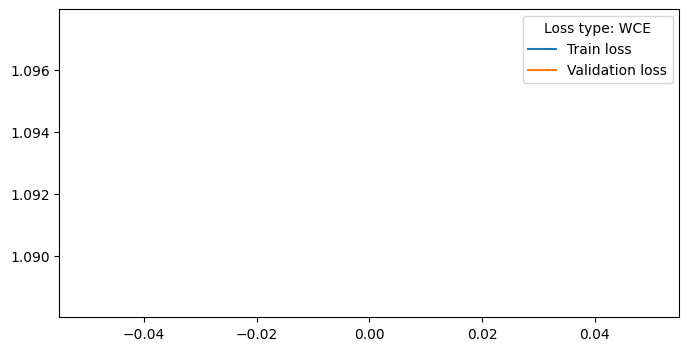

In [21]:
plt.figure(figsize=(8, 4))
plt.plot(train_loss, label='Train loss')
plt.plot(valid_loss, label='Validation loss')
plt.legend(title="Loss type: " + params['loss_op'])

if PLOT_SHOW:
    plt.show()
else:
    plt.savefig(PLOT_FOLDER+"/train_val_losses_demo.png")
    plt.close()

### Graphical comparison model prediction/ground truth

In [22]:
torch.no_grad()
model.eval()
batch = next(iter(test_loader))
batch = batch.to(DEVICE)
pred = model(batch)
pred

tensor([[0.2896, 0.3435, 0.3669],
        [0.2870, 0.3440, 0.3691],
        [0.2905, 0.3426, 0.3670],
        ...,
        [0.3187, 0.3439, 0.3375],
        [0.3181, 0.3447, 0.3373],
        [0.3187, 0.3428, 0.3385]], grad_fn=<SoftmaxBackward0>)

In [23]:
mesh = xr.open_dataset(MESH_PATH)
mesh_lon = mesh.lon[mesh.nodes].values
mesh_lat = mesh.lat[mesh.nodes].values

In [24]:
this_target = batch.y[:mesh.dims['nodes_subset']]
this_pred = []
for p in pred[:mesh.dims['nodes_subset']]:
    p = p.tolist()
    max_value = max(p)
    max_index = p.index(max_value)
    this_pred.append(max_index)

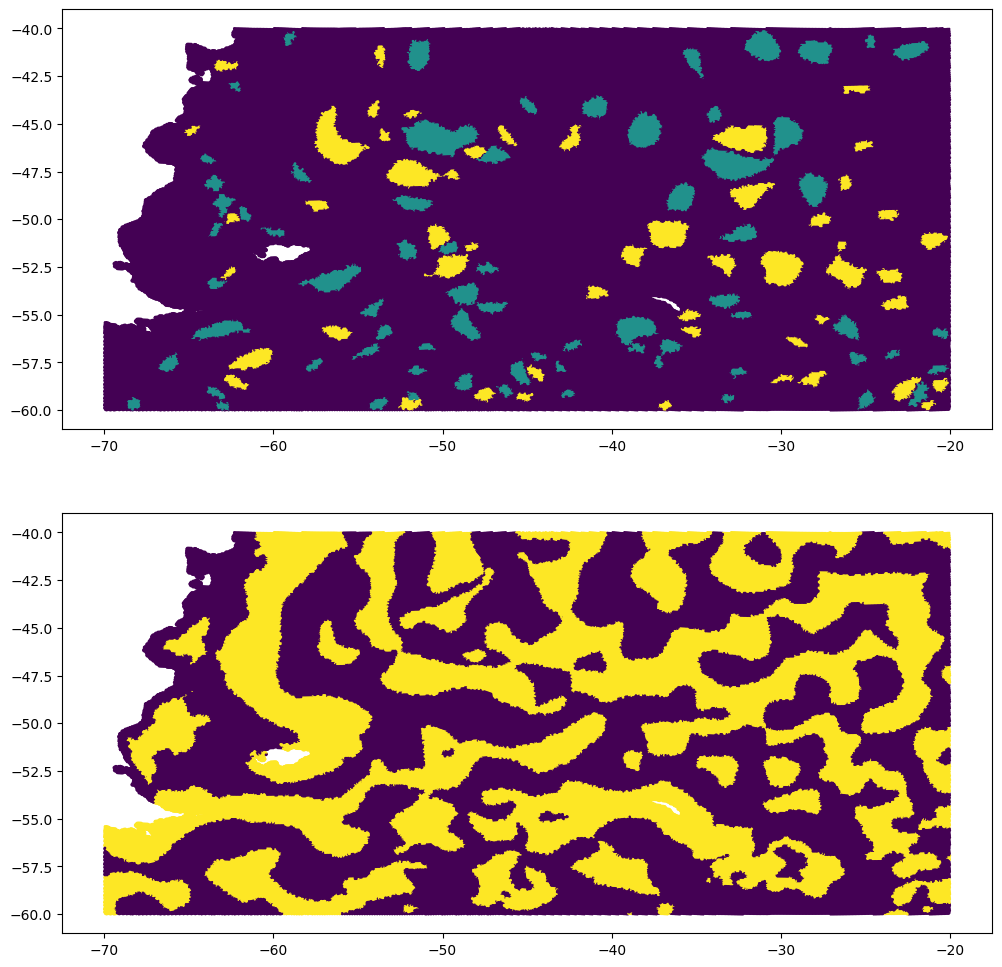

In [25]:
fig, axes = plt.subplots(2, 1, figsize=(12, 12))

im = axes[0].scatter(mesh_lon, mesh_lat, c=this_target, s=1)
im2 = axes[1].scatter(mesh_lon, mesh_lat, c=this_pred, s=1)

if PLOT_SHOW:
    plt.show()
else:
    plt.savefig(PLOT_FOLDER+"/pred_vs_ground_demo.png")
    plt.close()

### Accuracy calculation

In [26]:
torch.no_grad()
model.eval()
correct_pred = 0
tot_pred = 0
tot_background = 0

for batch in test_loader:
    batch = batch.to(DEVICE)
    pred = model(batch)
    tot_pred += len(pred)
    
    pred_values = []
    for p in pred:
        p = p.tolist()
        max_value = max(p)
        max_index = p.index(max_value)
        pred_values.append(max_index)
    
    for b in batch.y:
        if b==0:
            tot_background += 1
    
    if len(pred_values) != len(batch.y):
        raise ValueError("Just to be extra sure, but you should never see this error appear.")
    
    for i in range(len(batch.y)):
        if pred_values[i] == batch.y[i]:
            correct_pred += 1

print(f"Total background cells:\t{tot_background}")
print(f"Correct predictions:\t{correct_pred}")
print(f"Total predictions:\t{tot_pred}")
print(f"Graph U-Net accuracy:\t{correct_pred/tot_pred:.4f}")

Total background cells:	7728837
Correct predictions:	1088669
Total predictions:	8862832
Graph U-Net accuracy:	0.1228
